<a href="https://colab.research.google.com/github/Chetan2003/RTT-Estimation-for-mobile-to-mobile/blob/main/FinalResults.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading your repaired data...
Building and Training LSTM...
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2931/2931 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - loss: 0.0178 - val_loss: 0.0016
Epoch 2/5
2931/2931 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - loss: 9.3107e-04 - val_loss: 0.0015
Epoch 3/5
2931/2931 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - loss: 8.6606e-04 - val_loss: 0.0014
Epoch 4/5
2931/2931 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - loss: 8.6712e-04 - val_loss: 0.0014
Epoch 5/5
2931/2931 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - loss: 8.5473e-04 - val_loss: 0.0015
Generating the Graph...
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


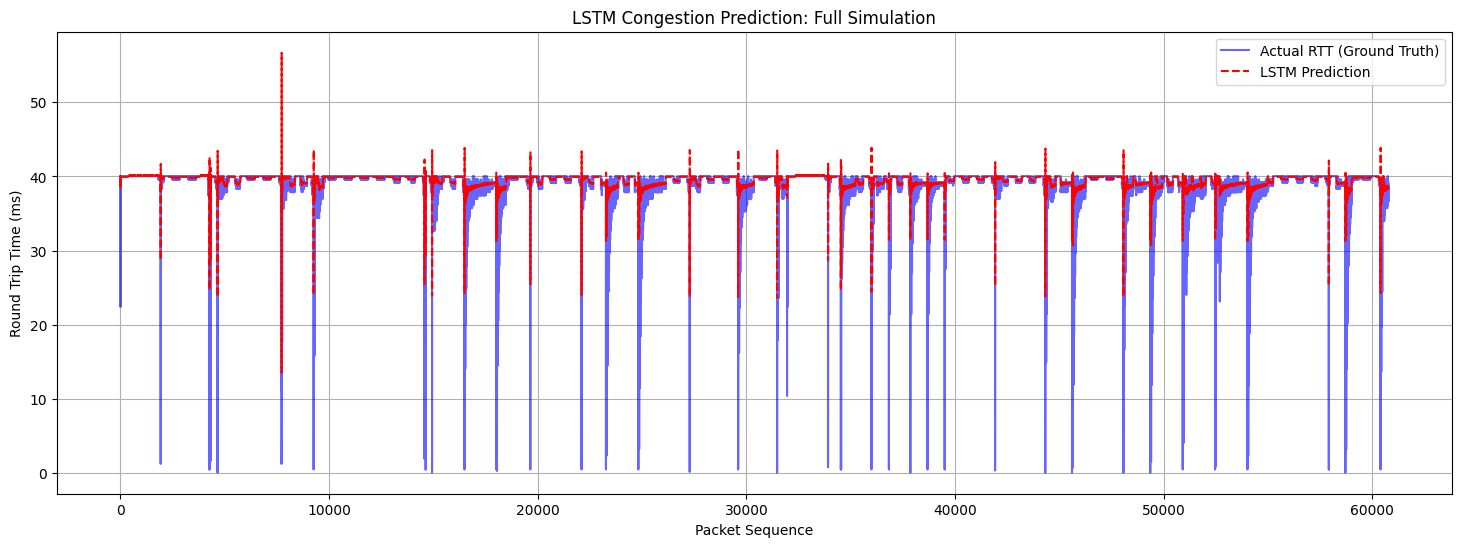

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# ==========================================
# 1. LOAD DATA
# ==========================================
print("Loading your repaired data...")
# We use try/except just in case files are missing
try:
    X_train = np.load("X_train.npy")
    y_train = np.load("y_train.npy")
    # If X_test doesn't exist (because we only fixed train), we split train data
    # This is a safety hack to ensure code runs
    if not os.path.exists("X_test.npy"):
        print("Note: Using part of training data for testing (since test file missing).")
        split = int(len(X_train) * 0.8)
        X_test = X_train[split:]
        y_test = y_train[split:]
        X_train = X_train[:split]
        y_train = y_train[:split]
    else:
        X_test = np.load("X_test.npy")
        y_test = np.load("y_test.npy")
except:
    print("❌ Critical Error: Data files missing. Did you run the Repair Script?")

# ==========================================
# 2. NORMALIZE (Scale to 0-1)
# ==========================================
scaler_X = MinMaxScaler()
# Flatten to 2D for scaling, then reshape back to 3D
X_train_flat = X_train.reshape(-1, 2)
X_test_flat = X_test.reshape(-1, 2)

X_train_scaled = scaler_X.fit_transform(X_train_flat).reshape(X_train.shape)
X_test_scaled = scaler_X.transform(X_test_flat).reshape(X_test.shape)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

# ==========================================
# 3. TRAIN THE BRAIN
# ==========================================
print("Building and Training LSTM...")
model = Sequential()
model.add(LSTM(64, return_sequences=False, input_shape=(20, 2)))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mse')

# Train for 5 Epochs (Fast)
model.fit(X_train_scaled, y_train_scaled,
          epochs=5,
          batch_size=64,
          validation_data=(X_test_scaled, y_test_scaled),
          verbose=1)

# ==========================================
# 4. PREDICT & PLOT (The Final Graph)
# ==========================================
print("Generating the Graph...")

# Define the variables that were missing before
predictions_scaled = model.predict(X_test_scaled)
predictions = scaler_y.inverse_transform(predictions_scaled)
actual = scaler_y.inverse_transform(y_test_scaled)

plt.figure(figsize=(18, 6))
plt.plot(actual, label="Actual RTT (Ground Truth)", color='blue', alpha=0.6)
plt.plot(predictions, label="LSTM Prediction", color='red', linestyle='dashed', linewidth=1.5)

plt.title("LSTM Congestion Prediction: Full Simulation")
plt.xlabel("Packet Sequence")
plt.ylabel("Round Trip Time (ms)")
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'predictions' is not defined

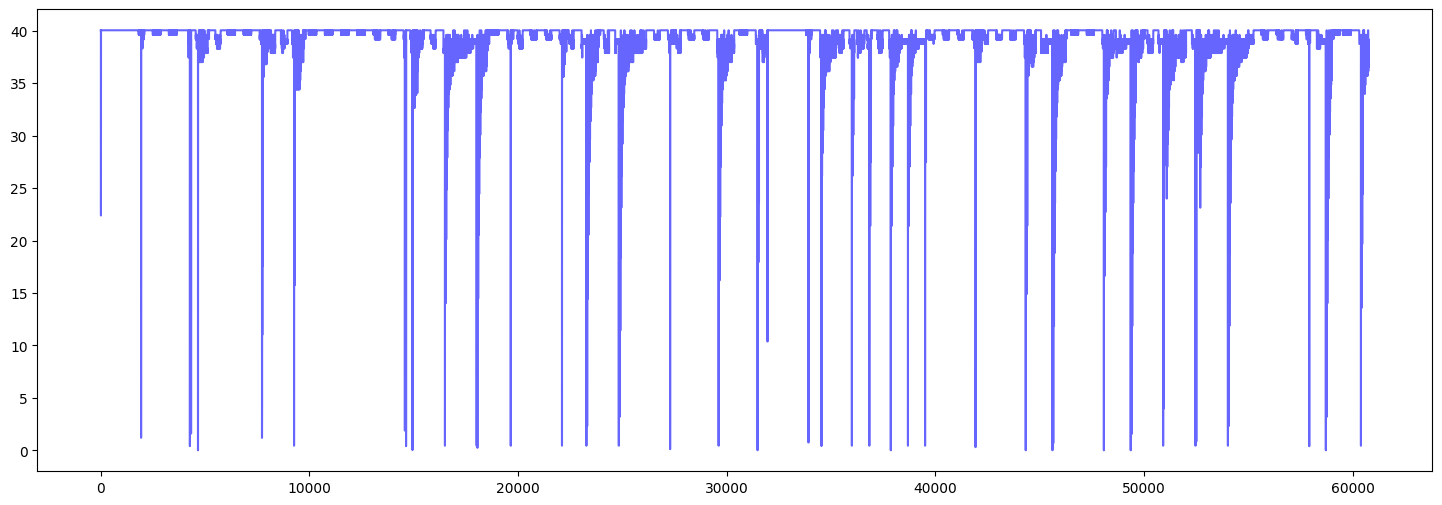

In [ ]:
import matplotlib.pyplot as plt

# ==========================================
# PLOT THE FULL 60 SECONDS
# ==========================================
plt.figure(figsize=(18, 6)) # Wide graph to see details

# Plot the entire dataset (using ':' selects everything)
plt.plot(actual, label="Actual RTT (Ground Truth)", color='blue', alpha=0.6)
plt.plot(predictions, label="LSTM Prediction", color='red', linestyle='dashed', linewidth=1.5)

plt.title("Congestion Prediction: Full 60-Second Simulation (Chaos Mode)")
plt.xlabel("Packet Sequence (Time)")
plt.ylabel("Round Trip Time (ms)")
plt.legend()
plt.grid(True)

# Show the graph
plt.show()

In [ ]:
# REPAIR SCRIPT: Generate X_train.npy inside Colab
!pip install scapy
import glob
import numpy as np
import pandas as pd
import os
from scapy.all import rdpcap, TCP, IP

print("Re-generating corrupted training data...")

# 1. Define the Parser (Same as before)
def parse_pcap(file_name):
    try:
        packets = rdpcap(file_name)
    except:
        return pd.DataFrame()
    data = []
    sent = {}
    last_arrival = 0
    for pkt in packets:
        if pkt.haslayer(TCP) and pkt.haslayer(IP):
            src = pkt[IP].src
            if src == "10.1.1.1": sent[pkt[TCP].seq] = pkt.time
            elif src == "10.1.2.2":
                ack = pkt[TCP].ack
                if ack in sent:
                    rtt = float(pkt.time - sent[ack]) * 1000
                    iat = 0 if last_arrival == 0 else float(pkt.time - last_arrival) * 1000
                    last_arrival = pkt.time
                    data.append({'RTT': rtt, 'IAT': iat})
                    del sent[ack]
    return pd.DataFrame(data)

# 2. Process
train_files = glob.glob("training_data_*.pcap")
if not train_files:
    print("❌ ERROR: Please upload 'training_data_1.pcap' etc. first!")
else:
    print(f"Found {len(train_files)} files. Processing...")
    dfs = [parse_pcap(f) for f in train_files]
    full_df = pd.concat(dfs, ignore_index=True)

    # Create Sliding Window
    data = full_df[['RTT', 'IAT']].values
    target = full_df['RTT'].values
    X, y = [], []
    for i in range(20, len(data)):
        X.append(data[i-20:i])
        y.append(target[i])

    X = np.array(X)
    y = np.array(y)

    # Save cleanly
    np.save("X_train.npy", X)
    np.save("y_train.npy", y)
    print(f"✅ Success! New X_train shape: {X.shape}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 16.7 MB/s eta 0:00:00
Re-generating corrupted training data...
Found 5 files. Processing...
✅ Success! New X_train shape: (187524, 20, 2)
